Task: start in any 4 corners, navigate to an hidden goal
Goal: learn a policy that minimizes distance between position x_t and reward location rloc
Model: linear recurrent network with parameters A to learn state transition and B to learn policy. x_t+1 = Ax_t + Bpsi_t + eps_t
Question: how to balance exploration vs exploitation?

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random, nn, lax, value_and_grad
import matplotlib.pyplot as plt
from backend import *
import numpy as np
import time

In [2]:
# inner loop
train_episodes = 1000
tmax = 300

actor_eta = 0.01

goalsize = 0.1
startcoord = [[-0.8,-0.8], [0.8,0.8] , [-0.8,0.8], [0.8,-0.8]]
goalcoord = jnp.array([0.0,0.0])

seed = 2021
maxspeed = 0.1

# outer loop
envsize=1
ndim = 2
npc = 21
sigma = 0.25
nact = 2
noise = 0.1

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-06-03 21:21:44.089748: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [3]:
def get_features(npc, envsize):
    # get feature centers for 2D env
    x = jnp.linspace(-envsize,envsize,npc)
    xx,yy = jnp.meshgrid(x,x)
    lambdas = jnp.concatenate([xx.reshape(-1)[:,None],yy.reshape(-1)[:,None]],axis=1)
    return lambdas, sigma

def get_params(ndim, npc, seed):
    # get state transtion matrix
    a_mat = jnp.eye(ndim)  # orthogonal transitions

    # get random policy
    b_key = random.PRNGKey(seed)
    b_mat = 1e-1 * random.normal(b_key, (ndim,npc**2))
    return [a_mat, b_mat]  

def predict_features(pc_params, x):
    lambdas, sigma = pc_params
    exponent = np.sum(((x-lambdas)/sigma)**2,axis=1)
    pcact = jnp.exp(-exponent/2)
    return pcact

def predict_nextstate_action(params,pc_params, x):
    psi = predict_features(pc_params, x)
    # A - fix/learn state transition, B - learn policy 
    A, B  = params
    action = B @ psi
    x1 = A @ x + action
    return x1, action

predict_nextstate_action_vmap = vmap(predict_nextstate_action, in_axes=(None, None, 0))

def loss(params,pc_params, x, rloc):
    x_preds, actions = predict_nextstate_action_vmap(params, pc_params, x)
    return jnp.mean((rloc - x_preds) ** 2)

@jit
def update(params, pc_params, coords, actions, errors, rloc, learning_rate):
    error, grads = value_and_grad(loss, argnums=0, has_aux=False)(params, pc_params, coords, rloc)
    A, B = params
    A -= learning_rate * grads[0]
    B -= learning_rate * grads[1]
    return (A, B), error

In [4]:
params = get_params(ndim, npc, seed)
initparams = params.copy()
pc_params = get_features(npc, envsize)

In [5]:
# inner loop training loop
def run_trial(params, env):
    coords = []
    actions = []
    errors = []

    state, goal, eucdist, done = env.reset()

    for i in range(tmax):

        nextstate, velocity = predict_nextstate_action(params,pc_params, state)

        newstate, error, done = env.step(velocity) 

        coords.append(nextstate)
        actions.append(velocity)
        errors.append(error)

        state = newstate.copy()

        if done:
            break

    return jnp.array(coords), jnp.array(actions), jnp.array(errors), i

In [6]:
latencys = []
coords_t = []
#errors_t = []
#params_t = []

env = TwoDimNav(startcoord=startcoord, goalcoord=goalcoord, goalsize=goalsize, tmax=tmax)

for t in range(train_episodes):

    coords, actions, errors, latency = run_trial(params, env)
    
    #params, jax_error = update(params, pc_params, coords, actions,errors, goalcoord, actor_eta)
    
    coords_t.append(coords)
    latencys.append(latency)
    #errors_t.append(jnp.mean(errors ** 2))
    #params_t.append(params)
    
    print(f"Trial {t+1}/{train_episodes}, latency {latency}, error {jnp.mean(errors ** 2)}")

Trial 1/1000, latency 299, error 0.661061704158783
Trial 2/1000, latency 299, error 0.701077401638031
Trial 3/1000, latency 299, error 0.661061704158783
Trial 4/1000, latency 299, error 0.661061704158783
Trial 5/1000, latency 299, error 0.5499182343482971
Trial 6/1000, latency 299, error 0.661061704158783
Trial 7/1000, latency 299, error 0.9759021401405334
Trial 8/1000, latency 299, error 0.661061704158783
Trial 9/1000, latency 299, error 0.701077401638031
Trial 10/1000, latency 299, error 0.701077401638031
Trial 11/1000, latency 299, error 0.701077401638031
Trial 12/1000, latency 299, error 0.661061704158783
Trial 13/1000, latency 299, error 0.701077401638031
Trial 14/1000, latency 299, error 0.661061704158783
Trial 15/1000, latency 299, error 0.661061704158783
Trial 16/1000, latency 299, error 0.701077401638031
Trial 17/1000, latency 299, error 0.5499182343482971
Trial 18/1000, latency 299, error 0.5499182343482971
Trial 19/1000, latency 299, error 0.9759021401405334
Trial 20/1000, l

In [12]:
# batch optimization
errors_t = []
params_t = []
params = initparams.copy()

for i in range(train_episodes):
    params, jax_error = update(params, pc_params, coords_t[i], actions , errors, goalcoord, actor_eta)
    errors_t.append(jax_error)
    params_t.append(params)
    print(jax_error)

0.7667836
1.3159567
0.69746614
0.6344538
0.49880046
0.5690404
2.6823812
0.4687723
1.192426
1.1298757
1.0706064
0.42622423
1.0143851
0.38766328
0.35264534
0.9610652
0.2521275
0.17084655
2.0537982
1.8178109
0.11470906
0.2473152
1.5824224
1.4005979
1.2396655
1.097225
0.768401
0.14841692
0.06763409
0.046111025
0.03156515
0.7150119
0.6775047
0.01654371
0.6396959
0.6061398
0.57434404
0.894257
0.11649829
0.006253517
0.5352169
0.0037152371
0.5063892
0.76682675
0.094378926
0.08585838
0.0017379777
0.0779262
0.6523622
0.5774044
0.057359803
0.5056609
0.44755968
0.45767838
0.43367
0.39170006
0.40931967
0.3455156
0.0010837732
0.30585882
0.38662198
0.00123311
0.36655757
0.034541354
0.03142599
0.34707883
0.028475782
0.02590855
0.023573322
0.32854843
0.021351183
0.019427774
0.017678196
0.0033308472
0.2569693
0.01499956
0.22645722
0.20043719
0.31274125
0.0034507741
0.0025832732
0.001996849
0.0016003812
0.012693125
0.29830804
0.011476757
0.0018287717
0.0014774168
0.17848124
0.2843691
0.269452
0.16045932


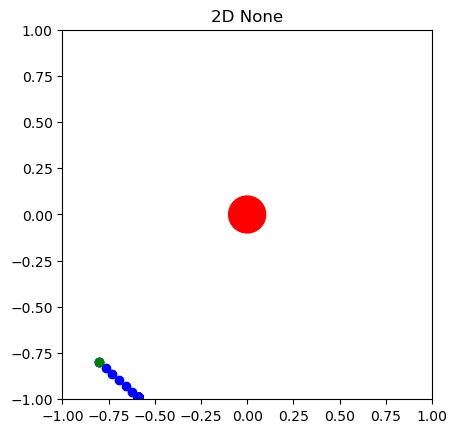

In [13]:
env.plot_trajectory()

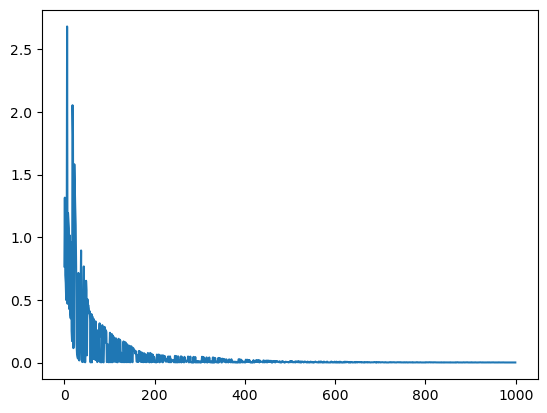

In [14]:
plt.figure()
plt.plot(errors_t)


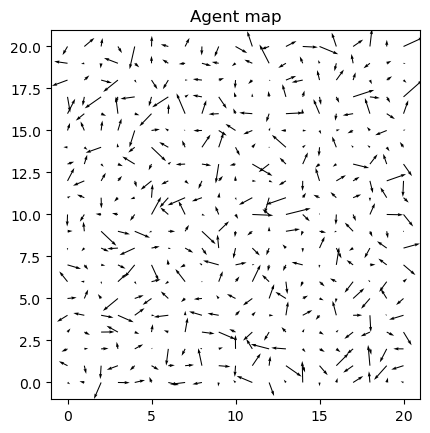

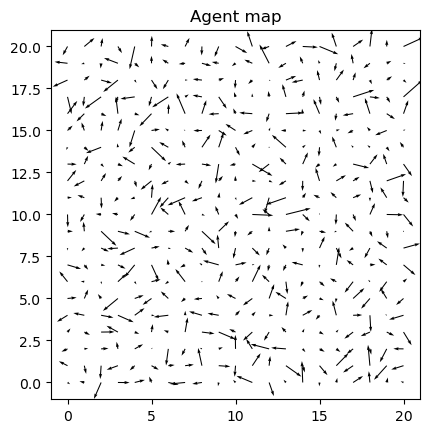

In [10]:
plot_maps(env, npc, initparams[1],critic_weights=None, title='Agent map')
plot_maps(env, npc, params_t[-1][1],critic_weights=None, title='Agent map')

In [15]:
for i in range(train_episodes):
    print(params_t[i][1][:,0])

[ 0.03418307 -0.02281312]
[ 0.03418307 -0.02281312]
[ 0.03421286 -0.02268971]
[ 0.03424126 -0.02257205]
[ 0.03424126 -0.02257205]
[ 0.03426906 -0.02246086]
[ 0.03426906 -0.02246086]
[ 0.03429089 -0.02235921]
[ 0.03429089 -0.02235921]
[ 0.03429089 -0.02235921]
[ 0.03429089 -0.02235921]
[ 0.03431195 -0.02226237]
[ 0.03431195 -0.02226237]
[ 0.03433211 -0.02217007]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03435132 -0.02208207]
[ 0.03436333 -0.02200765]
[ 0.03436333 -0.02200765]
[ 0.03436333 -0.02200765]
[ 0.03436333 -0.02200765]
[ 0.03436333 -0.02200765]
[ 0.03436333 -0.02200765]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03436204 -0.02194933]
[ 0.03435961

In [16]:
for i in range(train_episodes):
    print(params_t[i][0][:,0])

[ 0.99918854 -0.00337479]
[0.97464144 0.00333329]
[9.7386473e-01 1.1542975e-04]
[ 0.97312397 -0.00295353]
[0.9696518  0.00184669]
[ 0.9689262  -0.00105375]
[ 0.9392     -0.02871725]
[ 0.93862975 -0.03137016]
[ 0.9153901  -0.02453702]
[ 0.8927682  -0.01788555]
[ 0.8707477 -0.0114109]
[ 0.87019616 -0.01393877]
[ 0.84875906 -0.00764538]
[ 0.8482306  -0.01005555]
[ 0.84772664 -0.01235417]
[ 0.82685566 -0.00624508]
[ 0.8244238  -0.00280924]
[8.2242388e-01 1.6372884e-05]
[ 0.79728186 -0.0250912 ]
[ 0.77362835 -0.04871229]
[ 0.7719158  -0.04645606]
[ 0.7715987  -0.04840089]
[ 0.7493753 -0.0702839]
[ 0.7284676  -0.09087134]
[ 0.7087977 -0.1102399]
[ 0.69029236 -0.12846175]
[ 0.6725783  -0.12044126]
[ 0.67260695 -0.12196724]
[ 0.6711643  -0.12034744]
[ 0.6699774  -0.11901501]
[ 0.66900086 -0.11791881]
[ 0.6518805  -0.11025479]
[ 0.6352153  -0.10279451]
[ 0.63457584 -0.10196606]
[ 0.6183754  -0.09473234]
[ 0.6026057  -0.08769093]
[ 0.5872552  -0.08083672]
[ 0.5720593  -0.09869166]
[ 0.572116  -0